## Temporal_Classifier_V01
<br>

### Key Differences from "Devarshi_LightGBM_Classifier_Model.ipynb":
1. Dataset used: **'train_temporal_classification.parquet.gz'** AND **'test_temporal_classification.parquet.gz'**.
2. v01 makes use of the 'Jupyter Notebook enviroment'.
3. This data **includes** the time component.
4. **Label Encoding** has been done in an orderly manner for the ease of understanding.
5. For the 'CAQI_level' column, we **merged** 'vhigh' into the 'high' category with an intention to see an improvement in our model accuracy. 
6. The accuracy results of **all** the methods are mentioned in the notebook.
7. Merger technique which yielded the **best result** is shown in this notebook.
8. Like the nonTemporal dataset an attempt to improve accruacy using GridSearchCV was also made.
9. Codes that produced ineffctive results have been **#commented out**.
10. **Confusion Matrix** was included to improve results interpretation. 
11. **'TimeSeriesSplit'** is used a Cross validation method.
12. The Notebook has a **feature importance** section as well.
13. Added Train and Test 'CAQI_level' **plot**.
---

In [1]:
pip install lightgbm 

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install pyarrow

Note: you may need to restart the kernel to use updated packages.


In [3]:
import numpy as np
import pandas as pd
import re
import seaborn as sns
import matplotlib.pyplot as plt

import lightgbm as lgb
from lightgbm import LGBMClassifier
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import accuracy_score
%matplotlib inline

--- 

# Train Dataset:
- 'train_temporal_classification.parquet.gz'

In [4]:
train = pd.read_parquet("train_temporal_classification.parquet.gz", engine = "pyarrow") 
train.head()

,powiat_voivod,cloud_cover,wind_speed,humidity,precipitation,snow_depth,temperature,voivodship,animal stock - total,area by land - utilised agricultural area,...,season,CAQI_lag1,holiday_name,is_school_holiday,is_lockdown,is_have_coalplant,rolling7_CAQI,rolling30_CAQI,rolling90_CAQI,is_weekend
DATE,,,,,,,,,,,,,,,,,,,,,
2017-01-01,"powiat aleksandrowski, kujawsko-pomorskie",4.746750,0.0,88.4,1.0,0.0,1.8,kujawsko-pomorskie,44.997895,1.718015,...,Winter,24.968064,New Year's Day,0.0,0.0,0.0,24.968064,28.884791,47.077522,1
2017-01-01,"powiat augustowski, podlaskie",8.000000,50.0,95.0,9.0,0.0,0.4,podlaskie,47.547318,4.963793,...,Winter,61.553125,New Year's Day,0.0,0.0,0.0,61.553125,36.561883,54.128302,1
2017-01-01,"powiat bełchatowski, łódzkie",5.923833,0.0,80.0,0.0,5.0,0.0,łódzkie,43.636364,3.809493,...,Winter,11.000000,New Year's Day,0.0,0.0,1.0,11.000000,29.314815,48.801235,1
2017-01-01,"powiat biała podlaska, lubelskie",6.000000,0.0,78.0,0.0,0.0,0.9,lubelskie,21.265306,0.138255,...,Winter,71.000000,New Year's Day,0.0,0.0,0.0,71.000000,59.414286,70.084646,1
2017-01-01,"powiat białystok, podlaskie",8.000000,0.0,89.0,0.0,0.0,0.4,podlaskie,47.549020,0.305201,...,Winter,49.878097,New Year's Day,0.0,0.0,0.0,49.878097,33.337733,50.529500,1


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 300960 entries, 2017-01-01 to 2021-02-28
Columns: 131 entries, powiat_voivod to is_weekend
dtypes: float64(120), int32(1), int64(5), object(5)
memory usage: 301.9+ MB


In [6]:
train.shape

(300960, 131)

In [7]:
train.columns.tolist()

['powiat_voivod',
 'cloud_cover',
 'wind_speed',
 'humidity',
 'precipitation',
 'snow_depth',
 'temperature',
 'voivodship',
 'animal stock - total',
 'area by land - utilised agricultural area',
 'area by land - forests',
 'area by land - residential areas',
 'area by land - industrial lands',
 'area by land - recreational and rest areas',
 'area by land - lands under waters',
 'area by land - wasteland',
 'area by land - other area',
 'emission of particulates - fugitive',
 'emission of particulates - fuel combustion',
 'emission of particulates - cement/lime and refractory materials',
 'emission of particulates - silicon',
 'emission of particulates - chemical fertilizers',
 'emission of particulates - surface-active agents',
 'emission of particulates - carbon and graphite, soot',
 'emission of pollutant gases - fugitive',
 'emission of pollutant gases - sulphur dioxide',
 'emission of pollutant gases - nitrogen oxides',
 'emission of pollutant gases - carbon monoxide',
 'emission

In [8]:
# Remove any special characters from the column names
train.columns = [re.sub('[^0-9a-zA-Z]+', '_', col) for col in train.columns]

In [9]:
train['year'].max()

2021

In [10]:
train_start_date = '2017-01-01'
train_end_date = '2020-05-31'
train= train.loc[train_start_date:train_end_date]

In [11]:
train.shape

(246906, 131)

In [12]:
train['year'].max()

2020

In [13]:
train['year'].tail()

DATE
2020-05-31    2020
2020-05-31    2020
2020-05-31    2020
2020-05-31    2020
2020-05-31    2020
Name: year, dtype: int64

In [14]:
train.shape

(246906, 131)

In [15]:
train.columns.tolist()

['powiat_voivod',
 'cloud_cover',
 'wind_speed',
 'humidity',
 'precipitation',
 'snow_depth',
 'temperature',
 'voivodship',
 'animal_stock_total',
 'area_by_land_utilised_agricultural_area',
 'area_by_land_forests',
 'area_by_land_residential_areas',
 'area_by_land_industrial_lands',
 'area_by_land_recreational_and_rest_areas',
 'area_by_land_lands_under_waters',
 'area_by_land_wasteland',
 'area_by_land_other_area',
 'emission_of_particulates_fugitive',
 'emission_of_particulates_fuel_combustion',
 'emission_of_particulates_cement_lime_and_refractory_materials',
 'emission_of_particulates_silicon',
 'emission_of_particulates_chemical_fertilizers',
 'emission_of_particulates_surface_active_agents',
 'emission_of_particulates_carbon_and_graphite_soot',
 'emission_of_pollutant_gases_fugitive',
 'emission_of_pollutant_gases_sulphur_dioxide',
 'emission_of_pollutant_gases_nitrogen_oxides',
 'emission_of_pollutant_gases_carbon_monoxide',
 'emission_of_pollutant_gases_carbon_dioxide',
 'em

In [16]:
train['CAQI_level'].value_counts()

low       108092
vlow      104899
medium     26066
high        7003
vhigh        846
Name: CAQI_level, dtype: int64

In [17]:
# combine high and vhigh to a single category, as we want to see how it will affect the accuracy of model
train['CAQI_level'] = train['CAQI_level'].replace({'vhigh':'high'})

In [18]:
# The ordered mapping of the labels to their categories 
#mapping = {'vlow': 0, 'low': 1, 'medium': 2, 'high': 3, 'vhigh':4}
mapping = {'vlow': 0, 'low': 1, 'medium': 2, 'high': 3}
train['CAQI_level'] = train['CAQI_level'].replace(mapping)

In [19]:
train['CAQI_level'].value_counts()

1    108092
0    104899
2     26066
3      7849
Name: CAQI_level, dtype: int64

In [20]:
# encoding the other categorical columns:
cat_cols = ['powiat_voivod', 'voivodship', 'season', 'holiday_name']
for col in cat_cols:
    le = LabelEncoder()
    train['powiat_voivod_encoded'] = le.fit_transform(train['powiat_voivod'])
    train['voivodship_encoded'] = le.fit_transform(train['voivodship'])
    train['season_encoded'] = le.fit_transform(train['season'])
    train['holiday_name_encoded'] = le.fit_transform(train['holiday_name'])

In [21]:
train['voivodship_encoded']

DATE
2017-01-01     1
2017-01-01     8
2017-01-01    13
2017-01-01     2
2017-01-01     8
              ..
2020-05-31    12
2020-05-31     3
2020-05-31     3
2020-05-31    14
2020-05-31    14
Name: voivodship_encoded, Length: 246906, dtype: int32

In [22]:
# quick check for any nulls
train.isna().sum()

powiat_voivod            0
cloud_cover              0
wind_speed               0
humidity                 0
precipitation            0
                        ..
is_weekend               0
powiat_voivod_encoded    0
voivodship_encoded       0
season_encoded           0
holiday_name_encoded     0
Length: 135, dtype: int64

In [23]:
train.columns.tolist()

['powiat_voivod',
 'cloud_cover',
 'wind_speed',
 'humidity',
 'precipitation',
 'snow_depth',
 'temperature',
 'voivodship',
 'animal_stock_total',
 'area_by_land_utilised_agricultural_area',
 'area_by_land_forests',
 'area_by_land_residential_areas',
 'area_by_land_industrial_lands',
 'area_by_land_recreational_and_rest_areas',
 'area_by_land_lands_under_waters',
 'area_by_land_wasteland',
 'area_by_land_other_area',
 'emission_of_particulates_fugitive',
 'emission_of_particulates_fuel_combustion',
 'emission_of_particulates_cement_lime_and_refractory_materials',
 'emission_of_particulates_silicon',
 'emission_of_particulates_chemical_fertilizers',
 'emission_of_particulates_surface_active_agents',
 'emission_of_particulates_carbon_and_graphite_soot',
 'emission_of_pollutant_gases_fugitive',
 'emission_of_pollutant_gases_sulphur_dioxide',
 'emission_of_pollutant_gases_nitrogen_oxides',
 'emission_of_pollutant_gases_carbon_monoxide',
 'emission_of_pollutant_gases_carbon_dioxide',
 'em

In [24]:
train['year'].max()

2020

In [25]:
train.shape

(246906, 135)

--- 
# Test Dataset: 
- 'test_temporal_classification.parquet.gz'

In [26]:
test = pd.read_parquet("test_temporal_classification.parquet.gz", engine = "pyarrow") 
test.head()

,powiat_voivod,cloud_cover,wind_speed,humidity,precipitation,snow_depth,temperature,voivodship,animal stock - total,area by land - utilised agricultural area,...,season,CAQI_lag1,holiday_name,is_school_holiday,is_lockdown,is_have_coalplant,rolling7_CAQI,rolling30_CAQI,rolling90_CAQI,is_weekend
DATE,,,,,,,,,,,,,,,,,,,,,
2021-03-02,"powiat aleksandrowski, kujawsko-pomorskie",5.000000,0.0,92.5,0.0,0.0,2.7,kujawsko-pomorskie,39.393684,1.712729,...,Spring,23.821706,Non Holiday,0.0,0.0,0.0,41.629324,44.641164,33.798813,0
2021-03-02,"powiat augustowski, podlaskie",7.000000,60.0,90.0,0.0,0.0,2.3,podlaskie,51.660036,4.947356,...,Spring,20.593006,Non Holiday,0.0,0.0,0.0,51.103275,39.976399,33.184952,0
2021-03-02,"powiat bełchatowski, łódzkie",4.846046,0.0,85.0,0.0,0.0,3.7,łódzkie,42.485537,3.735109,...,Spring,21.945455,Non Holiday,0.0,0.0,1.0,42.552922,40.208157,33.076156,0
2021-03-02,"powiat biała podlaska, lubelskie",6.000000,0.0,89.0,0.0,0.0,3.7,lubelskie,19.326531,0.136890,...,Spring,33.166667,Non Holiday,0.0,0.0,0.0,58.112608,57.730682,48.761292,0
2021-03-02,"powiat białystok, podlaskie",7.000000,0.0,91.5,0.0,0.0,2.5,podlaskie,51.666667,0.304191,...,Spring,21.850145,Non Holiday,0.0,0.0,0.0,50.750194,46.867564,38.484418,0


In [27]:
test.shape

(60390, 131)

In [28]:
test.columns.tolist()

['powiat_voivod',
 'cloud_cover',
 'wind_speed',
 'humidity',
 'precipitation',
 'snow_depth',
 'temperature',
 'voivodship',
 'animal stock - total',
 'area by land - utilised agricultural area',
 'area by land - forests',
 'area by land - residential areas',
 'area by land - industrial lands',
 'area by land - recreational and rest areas',
 'area by land - lands under waters',
 'area by land - wasteland',
 'area by land - other area',
 'emission of particulates - fugitive',
 'emission of particulates - fuel combustion',
 'emission of particulates - cement/lime and refractory materials',
 'emission of particulates - silicon',
 'emission of particulates - chemical fertilizers',
 'emission of particulates - surface-active agents',
 'emission of particulates - carbon and graphite, soot',
 'emission of pollutant gases - fugitive',
 'emission of pollutant gases - sulphur dioxide',
 'emission of pollutant gases - nitrogen oxides',
 'emission of pollutant gases - carbon monoxide',
 'emission

In [29]:
test['year'].tail()

DATE
2021-12-31    2021
2021-12-31    2021
2021-12-31    2021
2021-12-31    2021
2021-12-31    2021
Name: year, dtype: int64

In [30]:
test['CAQI_level'].value_counts()

vlow      31913
low       24346
medium     3683
high        435
vhigh        13
Name: CAQI_level, dtype: int64

In [31]:
# combine high and vhigh to a single category, as we want to see how it will affect the accuracy of model
test['CAQI_level'] = test['CAQI_level'].replace({'vhigh':'high'})

In [32]:
test['CAQI_level'].value_counts()

vlow      31913
low       24346
medium     3683
high        448
Name: CAQI_level, dtype: int64

In [33]:
# The ordered mapping of the labels to their categories 
#mapping = {'vlow': 0, 'low': 1, 'medium': 2, 'high': 3, 'vhigh':4}
mapping = {'vlow': 0, 'low': 1, 'medium': 2, 'high': 3}

test['CAQI_level'] = test['CAQI_level'].replace(mapping)

In [34]:
# encoding the other categorical columns:
cat_cols = ['powiat_voivod', 'voivodship', 'season', 'holiday_name']
for col in cat_cols:
    le = LabelEncoder()
    test['powiat_voivod_encoded'] = le.fit_transform(test['powiat_voivod'])
    test['voivodship_encoded'] = le.fit_transform(test['voivodship'])
    test['season_encoded'] = le.fit_transform(test['season'])
    test['holiday_name_encoded'] = le.fit_transform(test['holiday_name'])

In [35]:
# Remove any special characters from the column names
train.columns = [re.sub('[^0-9a-zA-Z]+', '_', col) for col in train.columns]

In [36]:
test['CAQI_level'].value_counts()

0    31913
1    24346
2     3683
3      448
Name: CAQI_level, dtype: int64

In [37]:
test['year'].max()

2021

In [38]:
test.shape

(60390, 135)

--- 

## Train and Test data are ready for use

In [39]:
# defining the features and target variable
X_train = train.drop(['CAQI_level','powiat_voivod', 'voivodship', 'season', 'holiday_name'], axis=1)
y_train = train['CAQI_level']
X_test = test.drop(['CAQI_level','powiat_voivod', 'voivodship', 'season', 'holiday_name',], axis=1)
y_test = test['CAQI_level']

In [40]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 246906 entries, 2017-01-01 to 2020-05-31
Columns: 130 entries, cloud_cover to holiday_name_encoded
dtypes: float64(120), int32(5), int64(5)
memory usage: 242.1 MB


In [41]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 60390 entries, 2021-03-02 to 2021-12-31
Columns: 130 entries, cloud_cover to holiday_name_encoded
dtypes: float64(120), int32(5), int64(5)
memory usage: 59.2 MB


In [42]:
X_test.shape

(60390, 130)

In [43]:
X_train.columns.tolist()

['cloud_cover',
 'wind_speed',
 'humidity',
 'precipitation',
 'snow_depth',
 'temperature',
 'animal_stock_total',
 'area_by_land_utilised_agricultural_area',
 'area_by_land_forests',
 'area_by_land_residential_areas',
 'area_by_land_industrial_lands',
 'area_by_land_recreational_and_rest_areas',
 'area_by_land_lands_under_waters',
 'area_by_land_wasteland',
 'area_by_land_other_area',
 'emission_of_particulates_fugitive',
 'emission_of_particulates_fuel_combustion',
 'emission_of_particulates_cement_lime_and_refractory_materials',
 'emission_of_particulates_silicon',
 'emission_of_particulates_chemical_fertilizers',
 'emission_of_particulates_surface_active_agents',
 'emission_of_particulates_carbon_and_graphite_soot',
 'emission_of_pollutant_gases_fugitive',
 'emission_of_pollutant_gases_sulphur_dioxide',
 'emission_of_pollutant_gases_nitrogen_oxides',
 'emission_of_pollutant_gases_carbon_monoxide',
 'emission_of_pollutant_gases_carbon_dioxide',
 'emission_of_pollutant_gases_methane

In [44]:
X_train.shape

(246906, 130)

In [45]:
y_train.shape

(246906,)

In [46]:
#from sklearn.model_selection import GridSearchCV
#from lightgbm import LGBMClassifier

# Define the parameter grid
#param_grid = {
#    'n_estimators': [100, 200, 500],
#    'learning_rate': [0.01, 0.05, 0.1],
#    'max_depth': [3, 5, 7]
#}

# Create the GridSearchCV object
#grid_search = GridSearchCV(
#    estimator=LGBMClassifier(),
#    param_grid=param_grid,
#    cv=5,  # specify the number of folds for cross-validation
#    scoring='accuracy',
#    n_jobs=-1  # use all available processors to speed up the computation
#)

# Fit the GridSearchCV object to the data
#grid_search.fit(X_train, y_train)

# Print the best hyperparameters
#print("Best hyperparameters:", grid_search.best_params_)


In [47]:
# Initialize the LightGBM classifier with the best hyperparameters
#lgbm = LGBMClassifier(
#    n_estimators=grid_search.best_params_['n_estimators'],
#    learning_rate=grid_search.best_params_['learning_rate'],
#    max_depth=grid_search.best_params_['max_depth']
#)

# Fit the model on the training set
#lgbm.fit(X_train, y_train)

In [48]:
# initializing the LightGBM classifier
lgbm = LGBMClassifier()

# we fit the model on the training set
lgbm.fit(X_train, y_train)

LGBMClassifier()

In [49]:
# Predict on the test set
y_pred = lgbm.predict(X_test)

# Accuracy score:
model_accuracy = accuracy_score(y_test, y_pred)
print("Model Accuracy:", model_accuracy)

Model Accuracy: 0.7519125683060109


---

Note:
1. Model Accuracy: 0.7519125683060109 (**75.19%**) (After we combined the 2 categorical values in 'CAQI_level')
2. Model Accuracy: 0.7480046365292267 (**74.80%**) (**w.o** combining the 2 categorical values).
<br>

- Comparing these two results, we can see that there is a minor difference in accuracy between the different preprocessing techniques. Specifically, combining the 'high' and 'vhigh' values in the 'CAQI_level' column slightly increased the accuracy of the model, while not combining them resulted in a slightly lower accuracy.

3. Model Accuracy: **74.65%** (With best LightGBM hyperparameters employed by GridsearchCV + combined values)
4. Model Accuracy: **74.71%** (With best LightGBM hyperparameters employed by GridsearchCV + **w.o** combined values)
<br>

In order to show the better accuracy I have combined the 2 categories and skipped using GridSearchCV, in this notebook.

- Therefore, the overall accuracy of the model is 0.7519, indicating that **75.19%** of the predictions were correct

---

### Model Evaluation:

In [50]:
# Evaluating the model performance
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.81      0.83      0.82     31913
           1       0.70      0.71      0.71     24346
           2       0.56      0.35      0.43      3683
           3       0.46      0.24      0.31       448

    accuracy                           0.75     60390
   macro avg       0.63      0.53      0.57     60390
weighted avg       0.75      0.75      0.75     60390



Label encoding mapping: 
'vlow': 0, 'low': 1, 'medium': 2, 'high': 3

### F1 scores:
- F1 score is the harmonic mean of precision and recall, which means that the F1 score will tell you the model’s balanced ability to both capture positive cases (recall) and be accurate with the cases it does capture (precision).

- In this case, the F1-score for class 0 is 0.82, for class 1 it is 0.71, for class 2 it is 0.43, and for class 3 it is 0.31.

- View https://stephenallwright.com/good-f1-score/ to learn more about the F1 score and other classification measures.

In [51]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_test, y_pred)

print(cm)

[[26637  5166   100    10]
 [ 6271 17387   655    33]
 [  111  2212  1278    82]
 [    4    69   269   106]]


### Based on the confusion matrix, we can see that:

- **26,637** samples were correctly predicted as class 0 (true negatives).
- **17,387** samples were correctly predicted as class 1 (true positives).
- **1,278** samples were correctly predicted as class 2 (true positives).
- **106** samples were correctly predicted as class 3 (true positives).
<br>

- **6,271** samples were incorrectly predicted as class 0, when the actual class was 1 (false negatives).
- **2,212** samples were incorrectly predicted as class 0, when the actual class was 2 (false negatives).
- **269** samples were incorrectly predicted as class 0, when the actual class was 3 (false negatives).
<br>

- **5,166** samples were incorrectly predicted as class 1, when the actual class was 0 (false positives).
- **655** samples were incorrectly predicted as class 1, when the actual class was 2 (false positives).
- **33** samples were incorrectly predicted as class 1, when the actual class was 3 (false positives).
- **100** samples were incorrectly predicted as class 2, when the actual class was 0 (false positives).
- **82** samples were incorrectly predicted as class 2, when the actual class was 3 (false positives).
- **10** samples were incorrectly predicted as class 3, when the actual class was 0 (false positives).
- **69** samples were incorrectly predicted as class 3, when the actual class was 1 (false positives).
- **269** samples were incorrectly predicted as class 3, when the actual class was 2 (false positives).

Overall, the confusion matrix provides a summary of the model's performance and helps to evaluate how well the model is able to correctly classify the samples.

### Confusion matrix visualized:

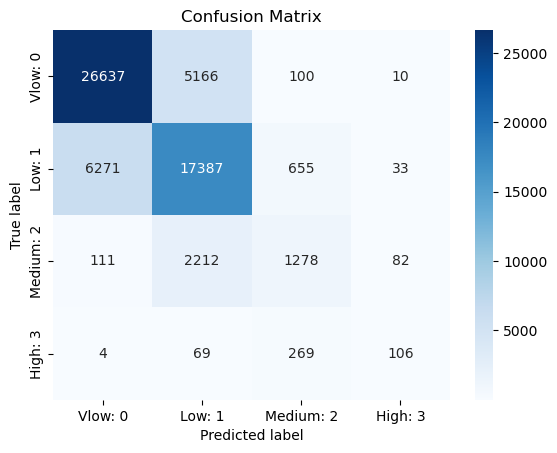

In [52]:
# confusion matrix
cm = np.array([[26637, 5166, 100, 10],
               [6271, 17387, 655, 33],
               [111, 2212, 1278, 82],
               [4, 69, 269, 106]])

# Class labels
class_names = ['Vlow: 0', 'Low: 1', 'Medium: 2', 'High: 3']

# Heatmap plot of the confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)

# Plot labels and title
plt.title('Confusion Matrix')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()


---

## Feature Importance:

In [53]:
# Lets check which features contributed the most to our target variable:
# Get feature importances
importances = lgbm.feature_importances_
feature_names = X_train.columns

# Creating a DataFrame to store feature importances
feature_importances = pd.DataFrame({'feature': X_train.columns, 'importance': importances})

# Sorting the features by importance in descending order
feature_importances = feature_importances.sort_values(by='importance', ascending=False)

# Print feature importances (a rough list)
print(feature_importances.values)

[['temperature' 1331]
 ['day' 1293]
 ['CAQI_lag1' 1089]
 ['wind_speed' 783]
 ['month' 775]
 ['dayofweek' 768]
 ['rolling30_CAQI' 622]
 ['rolling90_CAQI' 444]
 ['rolling7_CAQI' 442]
 ['cloud_cover' 437]
 ['humidity' 416]
 ['precipitation' 272]
 ['year' 261]
 ['season_encoded' 195]
 ['holiday_name_encoded' 174]
 ['snow_depth' 88]
 ['forest_fires_area_of_forest_fires_total' 74]
 ['crop_production_rape_and_turnip_rape_area_in_ha_total' 64]
 ['crop_production_permanent_meadows_area_in_ha_total' 63]
 ['animal_stock_total' 62]
 ['crop_production_cereals_grand_total_area_in_ha_total' 59]
 ['crop_production_potatoes_area_in_ha_total' 58]
 ['powiat_voivod_encoded' 57]
 ['is_school_holiday' 57]
 ['forest_fires_number_of_forest_fires_total' 57]
 ['crop_production_permanent_pastures_area_in_ha_total' 54]
 ['share_of_green_areas_share_of_green_areas_in_the_total_area' 51]
 ['area_by_land_utilised_agricultural_area' 47]
 ['area_by_land_residential_areas' 46]
 ['forest_area_forests_grand_total' 45]
 [

### Top 15 features:

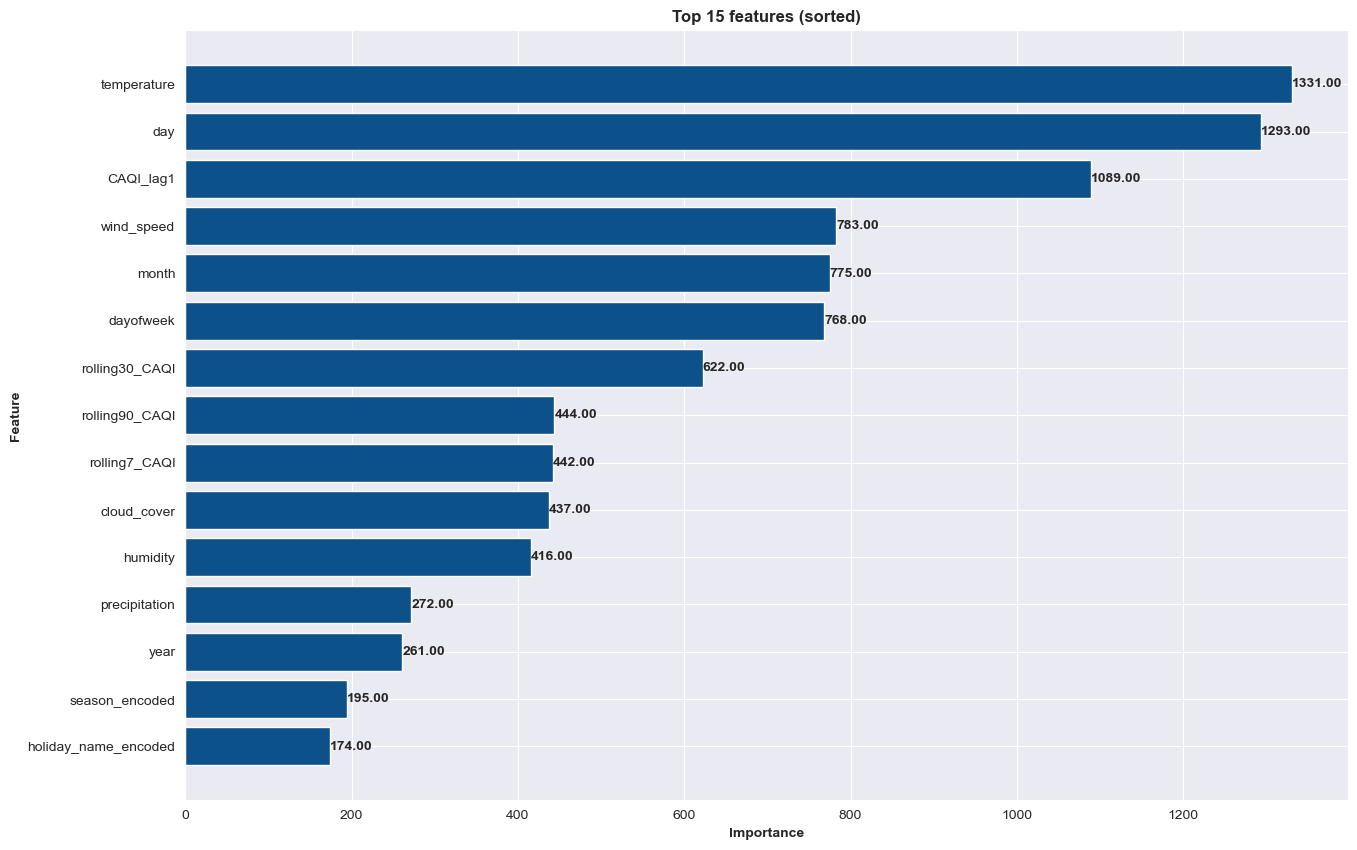

In [54]:
# get feature importances and corresponding feature names
importances = lgbm.feature_importances_
feature_names = X_train.columns

# create dataframe of feature names and importances
feature_importances = pd.DataFrame({'feature': feature_names, 'importance': importances})

# sort features by importance
feature_importances = feature_importances.sort_values('importance', ascending=False)
sns.set_style("darkgrid")

# we create a horizontal bar chart
plt.figure(figsize=(15, 10))
plt.barh(feature_importances['feature'][:15], feature_importances['importance'][:15], color='#0d518b')

# data labels
for index, value in enumerate(feature_importances['importance'][:15]):
    plt.text(value, index, f'{value:.2f}', ha='left', va='center', fontweight='bold')

# Chart title and axes labels
plt.title('Top 15 features (sorted)', fontweight='bold')
plt.xlabel('Importance', fontweight='bold')
plt.ylabel('Feature', fontweight='bold')

# Flip the order of the bars
plt.gca().invert_yaxis()

plt.show()

### Key observations:
- Temperatute by far has contributed the most to our target variable with a score of 1331.
- day, CAQI_lag values, month, Windspeed and day of the week too play a major in affecting our 'CAQI_level'.

### 15 Least important features:

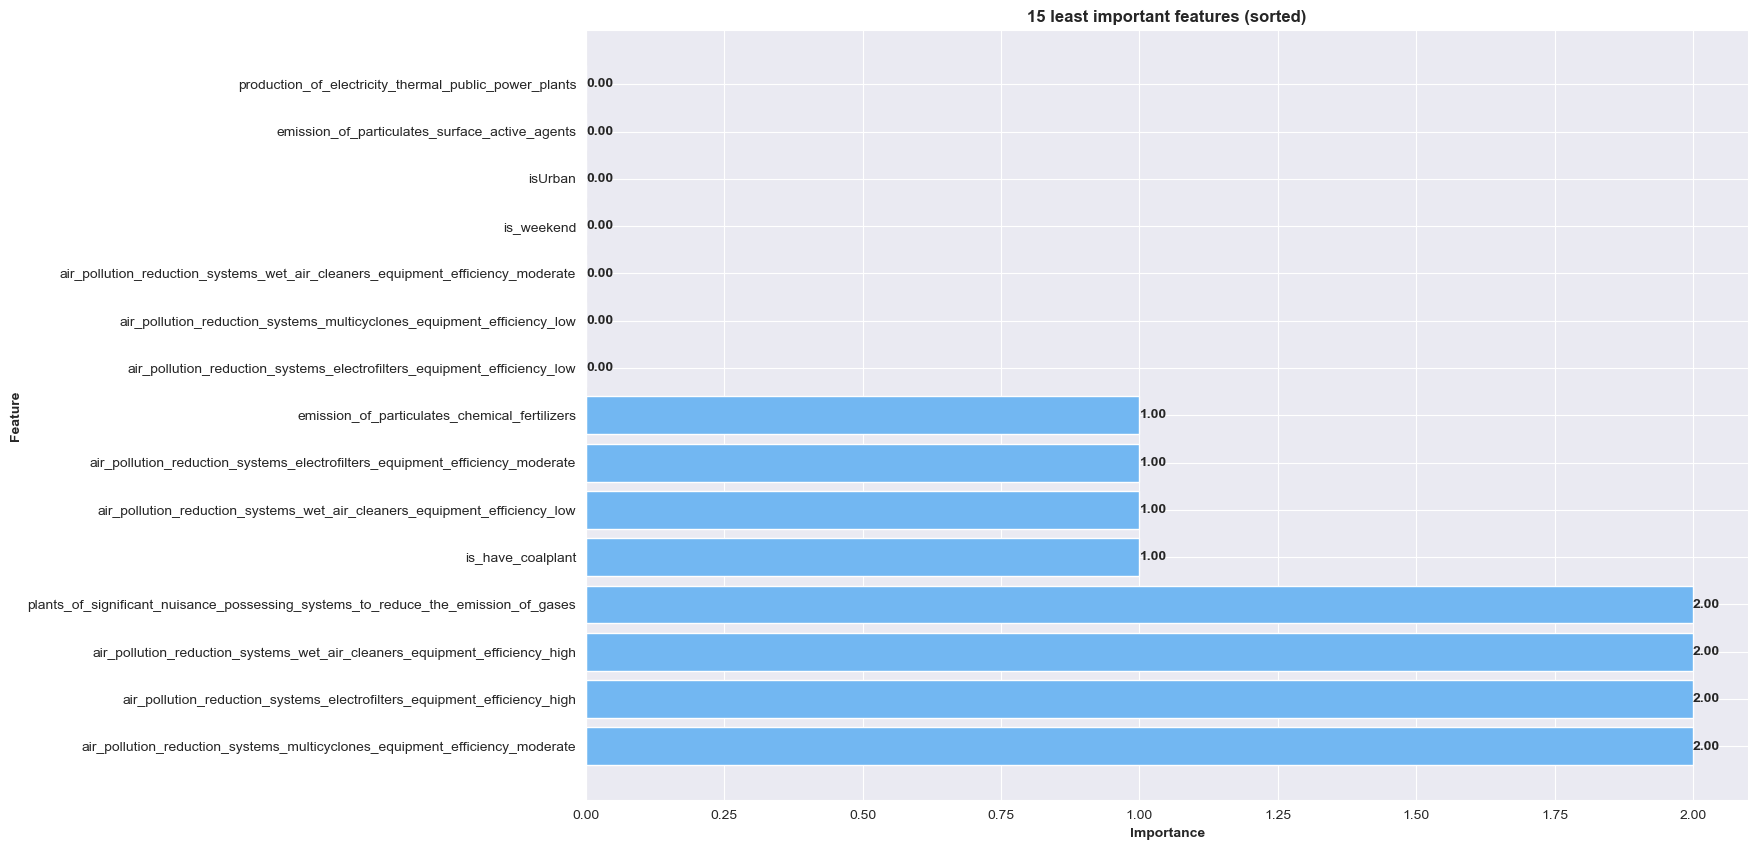

In [55]:
# get feature importances and corresponding feature names
importances = lgbm.feature_importances_
feature_names = X_train.columns

# create dataframe of feature names and importances
feature_importances = pd.DataFrame({'feature': feature_names, 'importance': importances})

# sort features by importance
feature_importances = feature_importances.sort_values('importance', ascending=True)

# Set the style
sns.set_style("darkgrid")

# create horizontal bar chart
plt.figure(figsize=(15, 10))
plt.barh(feature_importances['feature'][:15], feature_importances['importance'][:15], color='#72b7f2')

# add data labels
for index, value in enumerate(feature_importances['importance'][:15]):
    plt.text(value, index, f'{value:.2f}', ha='left', va='center', fontweight='bold')

# add chart title and axes labels
plt.title('15 least important features (sorted)', fontweight='bold')
plt.xlabel('Importance', fontweight='bold')
plt.ylabel('Feature', fontweight='bold')

# Flip the order of the bars
plt.gca().invert_yaxis()

# display chart
plt.show()

## Key Observations:
- 7 feautures in the data have made **zero contribution** to the target variable.
- Rest of the columns have the least contribution to out target variable.

---

### Cross Validation:

In [56]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import accuracy_score

# Lets create a TimeSeriesSplit object with the desired number of splits
tscv = TimeSeriesSplit(n_splits=5)

# The purpose of time series cross-validation is to simulate how the model will perform on new and unseen data, 
# so I will use the training set for defining X and y.
X = train.drop(['CAQI_level','powiat_voivod', 'voivodship', 'season', 'holiday_name'], axis=1)
y = train['CAQI_level']

# create an empty list to store the accuracies for each split
accuracy_list = []

In [57]:
# loop over each split and fit the model
for train_index, test_index in tscv.split(X):
    # split the data into training and testing sets
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # fit the LightGBM classifier on the training data
    clf = LGBMClassifier()
    clf.fit(X_train, y_train)
    
    # prediction on the testing data and calculate accuracy
    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    accuracy_list.append(accuracy)
    
# print the average accuracy across all splits
print('Average accuracy:', sum(accuracy_list)/len(accuracy_list))

Average accuracy: 0.7030205827318898


- Cross-validation using the TimeSeriesSplit method yields an average accuracy of 70.30% across all splits.
- This means that the model has moderate predictive power.

---

### Plotting train and test targets to visually check

In [58]:
y_train

DATE
2017-01-01    0
2017-01-01    2
2017-01-01    0
2017-01-01    2
2017-01-01    1
             ..
2019-11-06    1
2019-11-06    1
2019-11-06    1
2019-11-06    0
2019-11-06    0
Name: CAQI_level, Length: 205755, dtype: int64

In [59]:
X_train.index.year

Int64Index([2017, 2017, 2017, 2017, 2017, 2017, 2017, 2017, 2017, 2017,
            ...
            2019, 2019, 2019, 2019, 2019, 2019, 2019, 2019, 2019, 2019],
           dtype='int64', name='DATE', length=205755)

In [60]:
X_test.index.year

Int64Index([2019, 2019, 2019, 2019, 2019, 2019, 2019, 2019, 2019, 2019,
            ...
            2020, 2020, 2020, 2020, 2020, 2020, 2020, 2020, 2020, 2020],
           dtype='int64', name='DATE', length=41151)

In [61]:
# features and target variable for reference:

# X_train = train.drop(['CAQI_level','powiat_voivod', 'voivodship', 'season', 'holiday_name'], axis=1)
# y_train = train['CAQI_level']
# X_test = test.drop(['CAQI_level','powiat_voivod', 'voivodship', 'season', 'holiday_name',], axis=1)
# y_test = test['CAQI_level']

In [62]:
y_train.index

DatetimeIndex(['2017-01-01', '2017-01-01', '2017-01-01', '2017-01-01',
               '2017-01-01', '2017-01-01', '2017-01-01', '2017-01-01',
               '2017-01-01', '2017-01-01',
               ...
               '2019-11-06', '2019-11-06', '2019-11-06', '2019-11-06',
               '2019-11-06', '2019-11-06', '2019-11-06', '2019-11-06',
               '2019-11-06', '2019-11-06'],
              dtype='datetime64[ns]', name='DATE', length=205755, freq=None)

In [63]:
y_train.to_frame()

,CAQI_level
DATE,
2017-01-01,0
2017-01-01,2
2017-01-01,0
2017-01-01,2
2017-01-01,1
...,...
2019-11-06,1
2019-11-06,1
2019-11-06,1


In [64]:
y_test.to_frame()

,CAQI_level
DATE,
2019-11-06,0
2019-11-06,0
2019-11-06,0
2019-11-06,0
2019-11-06,0
...,...
2020-05-31,0
2020-05-31,0
2020-05-31,1


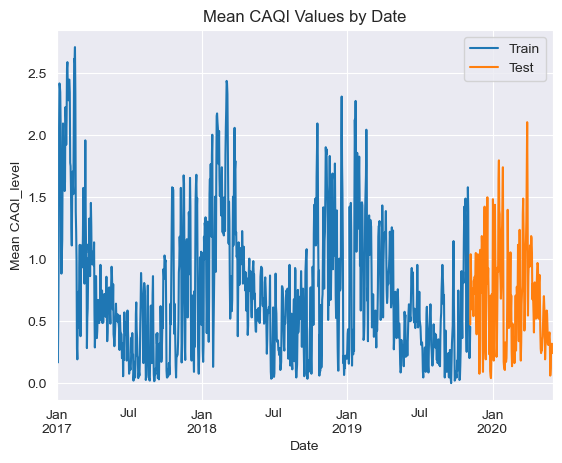

In [65]:

y_train.groupby('DATE').mean().plot()
y_test.groupby('DATE').mean().plot()

plt.legend(['Train', 'Test'])
plt.title('Mean CAQI Values by Date')
plt.xlabel('Date')
plt.ylabel('Mean CAQI_level')
plt.show()